In [64]:
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import os

# CQT Configuration 
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

def plot_cqt_with_pianoroll(audio_path, midi_path):
    cqt_list = []
    y, _ = librosa.load(audio_path, sr=sr)

    C = librosa.cqt(
        y, sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave
    )
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    # Load MIDI and get piano roll
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    fs_pianoroll = sr / hop_length  # Frame rate to match CQT
    piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

    # Align time axes
    n_frames = min(C_dB.shape[1], piano_roll.shape[1])
    return C_dB[:, :n_frames], piano_roll[:, :n_frames]



In [67]:
# audio_path = r'note_silence\audio'
# midi_path = r'note_silence\midi'

audio = r'piano_keys_5x_random.mp3'
midi = r'piano_keys_5x_random.mid'
num_sample =10
cqt_list = []
piano_list = []
# dura = '0_0312'
cqt , piano = plot_cqt_with_pianoroll(audio, midi)

for i in range(num_sample):
        cqt_list.append(cqt)
        piano_list.append(piano)
cqt_concat = np.concatenate(cqt_list, axis=1)  # along time axis
piano_concat = np.concatenate(piano_list, axis=1)

In [68]:
print(cqt_concat.shape)
print(piano_concat.shape)

(267, 441000)
(128, 441000)


In [69]:
# duration_sec = piano_concat.shape[1] * hop_length / sr

# # Plot setup
# fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# # Plot CQT 
# librosa.display.specshow(
#     cqt_concat[:,:],
#     sr=sr,
#     hop_length=hop_length,
#     x_axis='s',                  
#     y_axis='cqt_note',
#     fmin=fmin,
#     bins_per_octave=bins_per_octave,
#     cmap='magma',
#     ax=axs[0]
# )
# axs[0].set_title("CQT Spectrogram")
# axs[0].label_outer()  

# # Plot Piano Roll
# pitch_min = 21
# pitch_max = 108

# axs[1].imshow(
#     piano_concat[pitch_min:pitch_max+1, :],
#     aspect='auto',
#     origin='lower',
#     cmap='gray_r',
#     interpolation='nearest',
#     extent=[0, duration_sec, pitch_min, pitch_max]
# )

# axs[1].set_xlabel('Time (seconds)')
# axs[1].set_ylabel('MIDI Pitch (Note Names)')
# axs[1].set_title('Piano Roll')
# axs[1].set_ylim(pitch_min, pitch_max)

# # Label only natural C notes
# c_notes = [n for n in range(pitch_min, pitch_max+1)
#            if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
# axs[1].set_yticks(c_notes)
# axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

# plt.tight_layout()
# plt.show()


In [70]:
def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis] 

def create_sliding_windows_midi(midi, window_size=9, stride=1):
    pad = window_size // 2
    midi_padded = np.pad(midi, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
    num_time_bins = midi.shape[1]

    windows = np.array([
        midi_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows, len(windows)

In [71]:
X_input = create_sliding_windows(cqt_concat, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window Output Shape:", X_input.shape)

Y_output, num_windows_midi = create_sliding_windows_midi(piano_concat, window_size=9, stride=1)
print("Sliding Window MIDI Output Shape:", Y_output.shape)

Sliding Window Output Shape: (441000, 267, 9, 1)
Sliding Window MIDI Output Shape: (441000, 128, 9)


In [72]:
Y_output_flattened = np.mean(Y_output, axis=2) >= 45  # Shape: (n, 128)
# print(Y_output_flattened)
print("Xtrain : ",X_input.shape)
print("out : ",Y_output.shape)
print("Ytrain : ",Y_output_flattened.shape)

Xtrain :  (441000, 267, 9, 1)
out :  (441000, 128, 9)
Ytrain :  (441000, 128)


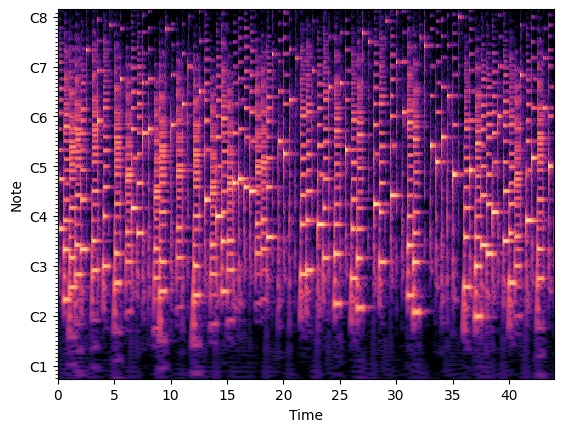

In [73]:
librosa.display.specshow(cqt_concat[:, :4410], sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='cqt_note',
                            fmin=fmin, bins_per_octave=bins_per_octave,
                            cmap='magma')


In [74]:
import tensorflow as tf
num_classes = 128
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(267, 9, 1), name="conv1"),
    tf.keras.layers.MaxPooling2D((2, 2), name="pool1"),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid', name="conv2"),
    tf.keras.layers.MaxPooling2D((2, 2), name="pool2"),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu', name="fc1"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="fc2")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 252, 8, 10)        330       
                                                                 
 pool1 (MaxPooling2D)        (None, 126, 4, 10)        0         
                                                                 
 conv2 (Conv2D)              (None, 116, 2, 20)        6620      
                                                                 
 pool2 (MaxPooling2D)        (None, 58, 1, 20)         0         
                                                                 
 flatten (Flatten)           (None, 1160)              0         
                                                                 
 fc1 (Dense)                 (None, 256)               297216    
                                                                 
 dropout (Dropout)           (None, 256)              

In [75]:
model.fit(X_input, Y_output_flattened, 
          epochs=10, 
          batch_size=256,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
          )
model.save("mono_all_5x.h5")

Epoch 1/10
1379/1379 [==============================] - 133s 96ms/step - loss: 0.0146 - binary_accuracy: 0.9967 - val_loss: 1.1694e-04 - val_binary_accuracy: 1.0000
Epoch 2/10
1379/1379 [==============================] - 124s 90ms/step - loss: 3.3190e-04 - binary_accuracy: 0.9999 - val_loss: 5.7956e-05 - val_binary_accuracy: 1.0000
Epoch 3/10
1379/1379 [==============================] - 123s 89ms/step - loss: 2.0850e-04 - binary_accuracy: 0.9999 - val_loss: 3.0889e-05 - val_binary_accuracy: 1.0000
Epoch 4/10
1379/1379 [==============================] - 111s 80ms/step - loss: 1.5549e-04 - binary_accuracy: 0.9999 - val_loss: 1.4060e-05 - val_binary_accuracy: 1.0000
Epoch 5/10
1379/1379 [==============================] - 108s 78ms/step - loss: 1.2480e-04 - binary_accuracy: 1.0000 - val_loss: 1.4144e-05 - val_binary_accuracy: 1.0000
Epoch 6/10
1379/1379 [==============================] - 107s 78ms/step - loss: 1.0686e-04 - binary_accuracy: 1.0000 - val_loss: 1.8624e-05 - val_binary_accurac